In [1]:
import torchvision
from torchvision.models.detection import fasterrcnn_resnet50_fpn
from torchvision.datasets import CocoDetection
from torchvision.transforms import ToTensor
from torch.utils.data import DataLoader
import torch
import torch.nn as nn
import matplotlib.pyplot as plt
from tqdm import tqdm
from torch.utils.data import Subset
import random
import os
import requests
import zipfile
from torch.utils.data import DataLoader, Subset
from torchvision.datasets import CocoDetection
from torchvision.transforms import ToTensor
from torchvision.models.detection import fasterrcnn_resnet50_fpn

In [2]:
train_zip_url = 'http://images.cocodataset.org/zips/train2017.zip'
train_zip_path = 'train2017.zip'
train_extract_folder = 'train2017'

if not os.path.exists(train_extract_folder):
    print("Downloading train2017.zip...")
    response = requests.get(train_zip_url, stream=True)
    with open(train_zip_path, 'wb') as f:
        for chunk in response.iter_content(chunk_size=1024 * 1024):
            if chunk:
                f.write(chunk)
    print("Download completed.")

    print("Extracting train2017.zip...")
    with zipfile.ZipFile(train_zip_path, 'r') as zip_ref:
        zip_ref.extractall('.')
    print("Extraction completed.")
else:
    print("train2017 folder already exists, skipping download.")

Download completed.
Extracting train2017.zip...
Extraction completed.


In [3]:
from torchvision.datasets import CocoDetection

class CocoSubset(CocoDetection):
    def __init__(self, root, annFile, indices, transform=None):
        super().__init__(root, annFile, transform)
        self.ids = [self.ids[i] for i in indices]

    def __getitem__(self, index):
        img, target = super().__getitem__(index)
        return img, target


In [4]:
from torchvision.models import resnet50
from torchvision.models.detection.backbone_utils import BackboneWithFPN
from torchvision.models._utils import IntermediateLayerGetter
from torchvision.models.detection import FasterRCNN



In [5]:
import os
import requests
import zipfile
import torch
from torch.utils.data import DataLoader, Subset
from torchvision.datasets import CocoDetection
from torchvision.transforms import ToTensor

# Download and extract annotations
ann_url = 'http://images.cocodataset.org/annotations/annotations_trainval2017.zip'
ann_zip_path = 'annotations_trainval2017.zip'
annotations_folder = 'annotations'
annotation_file = os.path.join(annotations_folder, 'instances_train2017.json')

if not os.path.exists(annotation_file):
    print("Downloading annotations_trainval2017.zip...")
    response = requests.get(ann_url, stream=True)
    with open(ann_zip_path, 'wb') as f:
        for chunk in response.iter_content(chunk_size=1024 * 1024):
            if chunk:
                f.write(chunk)
    print("Download completed.")

    print("Extracting annotations...")
    with zipfile.ZipFile(ann_zip_path, 'r') as zip_ref:
        zip_ref.extractall('.')
    print("Annotations extracted.")
else:
    print("Annotation file already exists, skipping download.")


# Custom collate function
def collate_fn(batch):
    return tuple(zip(*batch))

# Target preparation function
def prepare_target(target):
    boxes = []
    labels = []
    for annotation in target:
        boxes.append(annotation['bbox'])
        labels.append(annotation['category_id'])

    if len(boxes) == 0:
        return None

    boxes = torch.as_tensor(boxes, dtype=torch.float32)
    labels = torch.as_tensor(labels, dtype=torch.int64)
    boxes[:, 2] = boxes[:, 0] + boxes[:, 2]
    boxes[:, 3] = boxes[:, 1] + boxes[:, 3]
    return {'boxes': boxes, 'labels': labels}

# Load COCO Dataset (Subset)


# Assuming images are extracted to 'train2017' folder in the same directory
train_extract_folder = 'train2017'

train_dataset = CocoDetection(
    root=train_extract_folder,
    annFile=annotation_file,
    transform=ToTensor()
)

total_samples_train = len(train_dataset)
print('Total samples in full dataset:', total_samples_train)

# Subset for training and testing
train_num_samp = 2000
train_indices = list(range(0, train_num_samp))
test_indices = list(range(train_num_samp, train_num_samp * 2))

subset_train_dataset = CocoSubset(
    root=train_extract_folder,
    annFile=annotation_file,
    indices=train_indices,
    transform=ToTensor()
)

subset_test_dataset = CocoSubset(
    root=train_extract_folder,
    annFile=annotation_file,
    indices=test_indices,
    transform=ToTensor()
)


train_loader = DataLoader(subset_train_dataset, batch_size=2, shuffle=True, collate_fn=collate_fn)
test_loader = DataLoader(subset_test_dataset, batch_size=1, shuffle=False, collate_fn=collate_fn)

def get_custom_backbone():
    from torchvision.models._utils import IntermediateLayerGetter

    # Load ResNet-50 (not pretrained)
    backbone = resnet50(weights=None)

    # Return specific layers from the full model
    return_layers = {
        'layer1': '0',
        'layer2': '1',
        'layer3': '2',
        'layer4': '3'
    }

    # Wrap with IntermediateLayerGetter to access intermediate layers
    backbone = IntermediateLayerGetter(backbone, return_layers=return_layers)

    # Define the number of input channels from each layer
    in_channels_list = [256, 512, 1024, 2048]
    out_channels = 256

    # Build the final backbone with FPN
    backbone_with_fpn = BackboneWithFPN(
        backbone,
        return_layers=return_layers,
        in_channels_list=in_channels_list,
        out_channels=out_channels
    )

    return backbone_with_fpn


# ======== Define Faster R-CNN Model with Custom Backbone ========
backbone = get_custom_backbone()
model = FasterRCNN(backbone, num_classes=91)


print('Subset train samples:', len(subset_train_dataset))
print('Subset test samples:', len(subset_test_dataset))
print('Train batches:', len(train_loader))
print('Test batches:', len(test_loader))


Download completed.
Extracting annotations...
Annotations extracted.
loading annotations into memory...
Done (t=16.70s)
creating index...
index created!
Total samples in full dataset: 118287
loading annotations into memory...
Done (t=19.21s)
creating index...
index created!
loading annotations into memory...
Done (t=15.72s)
creating index...
index created!
Subset train samples: 2000
Subset test samples: 2000
Train batches: 1000
Test batches: 2000


In [6]:
model = fasterrcnn_resnet50_fpn(pretrained=True)
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model.to(device)

optimizer = torch.optim.SGD(model.parameters(), lr=0.005, momentum=0.9, weight_decay=0.0005)

/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=FasterRCNN_ResNet50_FPN_Weights.COCO_V1`. You can also use `weights=FasterRCNN_ResNet50_FPN_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/fasterrcnn_resnet50_fpn_coco-258fb6c6.pth" to /root/.cache/torch/hub/checkpoints/fasterrcnn_resnet50_fpn_coco-258fb6c6.pth
100%|██████████| 160M/160M [00:01<00:00, 149MB/s]


Epoch 1/5: 100%|██████████| 1000/1000 [10:21<00:00,  1.61it/s]


Epoch 1/5, Average Loss: 0.7232


Epoch 2/5: 100%|██████████| 1000/1000 [10:26<00:00,  1.60it/s]


Epoch 2/5, Average Loss: 0.6097


Epoch 3/5: 100%|██████████| 1000/1000 [10:22<00:00,  1.61it/s]


Epoch 3/5, Average Loss: 0.5443


Epoch 4/5: 100%|██████████| 1000/1000 [10:21<00:00,  1.61it/s]


Epoch 4/5, Average Loss: 0.5044


Epoch 5/5: 100%|██████████| 1000/1000 [10:20<00:00,  1.61it/s]


Epoch 5/5, Average Loss: 0.4538


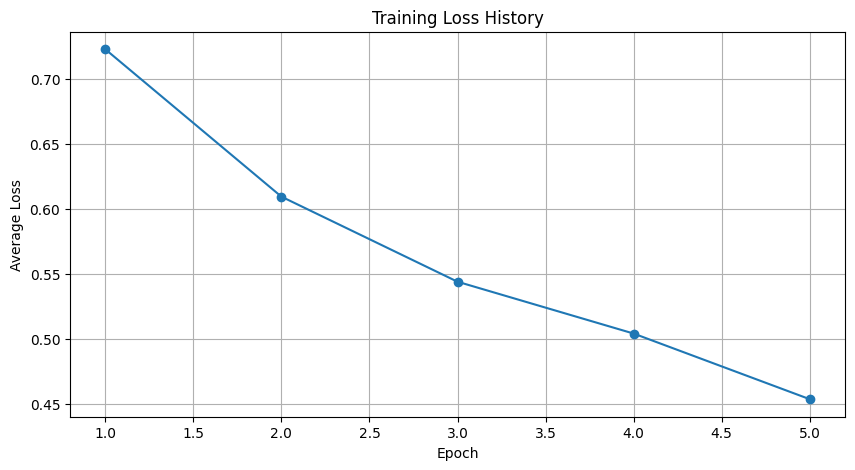

In [8]:
num_epochs = 5
train_losses = []

for epoch in range(num_epochs):
    model.train()
    epoch_loss = 0
    for images, targets in tqdm(train_loader, desc=f"Epoch {epoch+1}/{num_epochs}"):
        images = [image.to(device) for image in images]
        prepared_targets = [prepare_target(t) for t in targets]

        # Filter out images without annotations
        valid_images = []
        valid_targets = []
        for img, tgt in zip(images, prepared_targets):
            if tgt is not None:
                valid_images.append(img)
                valid_targets.append({k: v.to(device) for k, v in tgt.items()})

        if len(valid_images) == 0:
            continue  # Skip this batch if no valid images


        loss_dict = model(valid_images, valid_targets)
        losses = sum(loss for loss in loss_dict.values())
        #print('losses:', losses.item())

        optimizer.zero_grad()
        losses.backward()
        optimizer.step()

        epoch_loss += losses.item()

    avg_loss = epoch_loss / len(train_loader)
    train_losses.append(avg_loss)
    print(f"Epoch {epoch+1}/{num_epochs}, Average Loss: {avg_loss:.4f}")

# Plot training history
plt.figure(figsize=(10, 5))
plt.plot(range(1, num_epochs+1), train_losses, marker='o')
plt.title('Training Loss History')
plt.xlabel('Epoch')
plt.ylabel('Average Loss')
plt.grid(True)
plt.savefig('training_history.png')
plt.show()

Testing:   0%|          | 0/2000 [00:00<?, ?it/s]/usr/local/lib/python3.11/dist-packages/torchvision/utils.py:233: UserWarning: Argument 'font_size' will be ignored since 'font' is not set.
  warnings.warn("Argument 'font_size' will be ignored since 'font' is not set.")


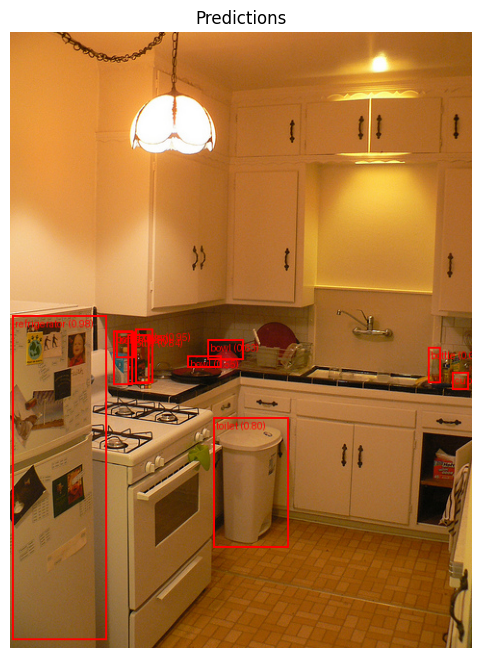

Testing:   0%|          | 1/2000 [00:00<28:13,  1.18it/s]

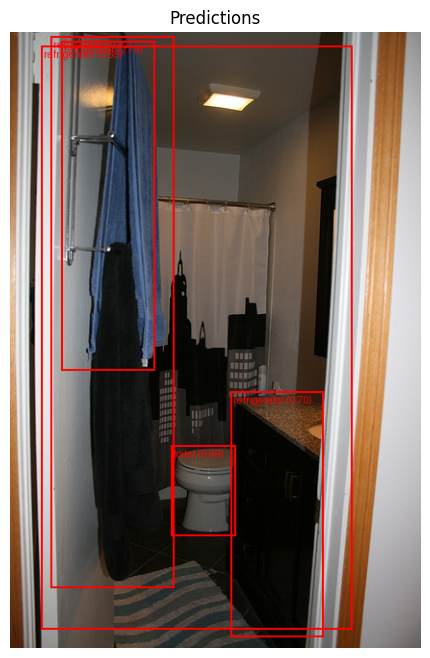

Testing:   0%|          | 2/2000 [00:01<21:41,  1.53it/s]

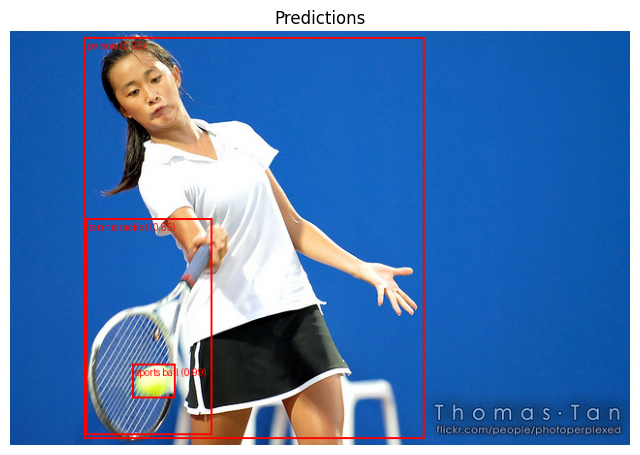

Testing:   0%|          | 3/2000 [00:01<20:31,  1.62it/s]

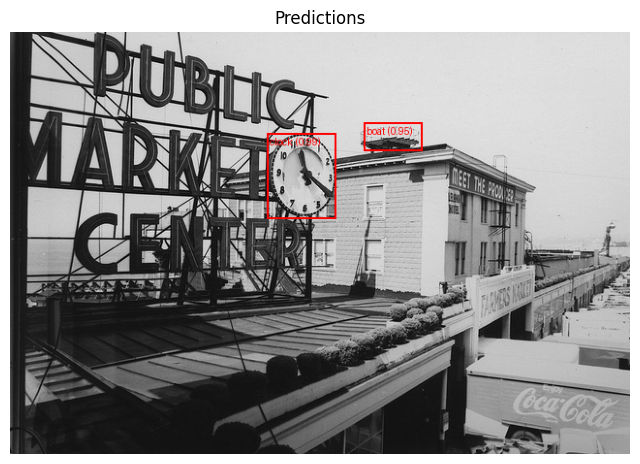

Testing:   0%|          | 4/2000 [00:02<19:18,  1.72it/s]

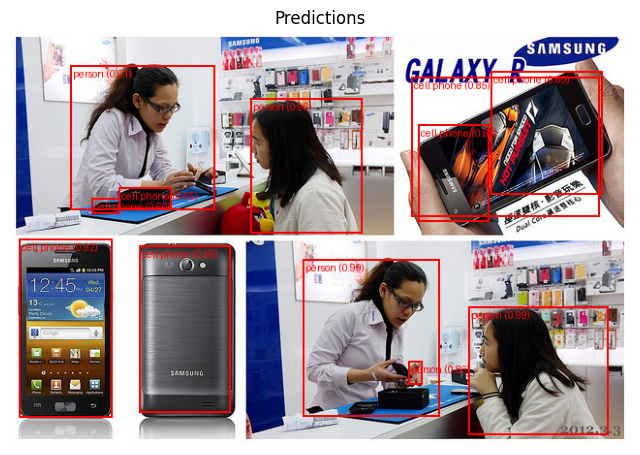

Testing: 100%|██████████| 2000/2000 [07:38<00:00,  4.36it/s]


In [9]:
from torchvision.utils import draw_bounding_boxes
from torchvision.transforms.functional import to_pil_image
import torchvision.transforms.functional as F
import matplotlib.pyplot as plt
import numpy as np
import os

# Set model to evaluation mode
model.eval()

# Create output folder
os.makedirs("test_outputs", exist_ok=True)

# Category names from COCO (id-to-name mapping)
coco_categories = subset_test_dataset.coco.loadCats(subset_test_dataset.coco.getCatIds())
id_to_name = {cat['id']: cat['name'] for cat in coco_categories}

# Inference loop
with torch.no_grad():
    for i, (images, targets) in enumerate(tqdm(test_loader, desc="Testing")):
        image = images[0].to(device)
        target = targets[0]  # ground truth, if needed
        output = model([image])[0]  # inference on single image

        # Filter predictions with score > threshold
        threshold = 0.5
        boxes = output['boxes'][output['scores'] > threshold]
        labels = output['labels'][output['scores'] > threshold]
        scores = output['scores'][output['scores'] > threshold]

        if boxes.nelement() == 0:
            continue  # skip empty predictions

        # Annotate image
        drawn = draw_bounding_boxes(
            (image.cpu() * 255).byte(),
            boxes.cpu(),
            labels=[id_to_name.get(lbl.item(), str(lbl.item())) + f" ({s:.2f})" for lbl, s in zip(labels, scores)],
            colors="red",
            width=2,
            font_size=16
        )
        pil_img = to_pil_image(drawn)

        # Save or show result
        pil_img.save(f"test_outputs/pred_{i}.png")

        if i < 5:  # Also show first few results
            plt.figure(figsize=(8, 8))
            plt.imshow(pil_img)
            plt.axis("off")
            plt.title("Predictions")
            plt.show()


In [10]:
pip install pycocotools


In [17]:
import torch
import json
from tqdm import tqdm
from pycocotools.coco import COCO
from pycocotools.cocoeval import COCOeval

def coco_evaluation(model, dataset, dataloader, device, result_file='coco_results.json'):
    model.eval()
    results = []
    image_ids = []

    print("\n🔍 Running inference for COCO Evaluation...")

    with torch.no_grad():
        for images, targets in tqdm(dataloader):
            images = [img.to(device) for img in images]
            outputs = model(images)

            for i in range(len(outputs)):
                output = outputs[i]
                target = targets[i]

                if len(target) == 0:
                    continue

                image_id = target[0]['image_id']
                boxes = output['boxes'].cpu().tolist()
                scores = output['scores'].cpu().tolist()
                labels = output['labels'].cpu().tolist()

                for box, score, label in zip(boxes, scores, labels):
                    x1, y1, x2, y2 = box
                    width = x2 - x1
                    height = y2 - y1

                    results.append({
                        'image_id': image_id,
                        'category_id': label,
                        'bbox': [x1, y1, width, height],
                        'score': score
                    })
                image_ids.append(image_id)

    # Save results to JSON
    with open(result_file, 'w') as f:
        json.dump(results, f)

    # Load GT and DT annotations
    coco_gt = dataset.coco
    coco_dt = coco_gt.loadRes(result_file)

    print("\n📊 Evaluating using COCO API...")
    coco_eval = COCOeval(coco_gt, coco_dt, iouType='bbox')
    coco_eval.params.imgIds = image_ids
    coco_eval.evaluate()
    coco_eval.accumulate()

    print("\n📈 COCO Evaluation Metrics (AP, mAP, AR):")
    coco_eval.summarize()


In [18]:
coco_evaluation(model, subset_test_dataset, test_loader, device)



🔍 Running inference for COCO Evaluation...


100%|██████████| 2000/2000 [04:07<00:00,  8.07it/s]


Loading and preparing results...
DONE (t=0.37s)
creating index...
index created!

📊 Evaluating using COCO API...
Running per image evaluation...
Evaluate annotation type *bbox*
DONE (t=10.94s).
Accumulating evaluation results...
DONE (t=2.04s).

📈 COCO Evaluation Metrics (AP, mAP, AR):
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=   all | maxDets=100 ] = 0.242
 Average Precision  (AP) @[ IoU=0.50      | area=   all | maxDets=100 ] = 0.446
 Average Precision  (AP) @[ IoU=0.75      | area=   all | maxDets=100 ] = 0.244
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= small | maxDets=100 ] = 0.160
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=medium | maxDets=100 ] = 0.281
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= large | maxDets=100 ] = 0.305
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets=  1 ] = 0.237
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets= 10 ] = 0.391
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets=100 ] =

In [19]:
pip install torchinfo fvcore


     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 50.2/50.2 kB 2.9 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 42.2/42.2 kB 4.0 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Created wheel for fvcore: filename=fvcore-0.1.5.post20221221-py3-none-any.whl size=61397 sha256=37213e03c2c3fc699650522ca8c9c793ae7ac532247f08e74418f11e299fdf6e
  Stored in directory: /root/.cache/pip/wheels/65/71/95/3b8fde5c65c6e4a806e0867c1651dcc71a1cb2f3430e8f355f
  Created wheel for iopath: filename=iopath-0.1.10-py3-none-any.whl size=31527 sha256=9d6de771a62e7ddf2fd6b8f59e13b0c729decb9d3abb7b4927db3f5bbe570646
  Stored in directory: /root/.cache/pip/wheels/ba/5e/16/6117f8fe7e9c0c161a795e10d94645ebcf301ccbd01f66d8ec
Successfully built fvcore iopath


In [20]:
from torchinfo import summary
from fvcore.nn import FlopCountAnalysis, parameter_count

# Example input (batch size 1, 3x800x800 image like COCO)
sample_input = torch.randn(1, 3, 800, 800).to(device)

# Total parameters
params = parameter_count(model)
total_params = sum(params.values())
print(f"\nTotal Parameters: {total_params:,}")

# FLOPs
flops = FlopCountAnalysis(model, sample_input)
print(f"Total FLOPs: {flops.total():,.0f}")
print(f"FLOPs (in GFLOPs): {flops.total() / 1e9:.2f} GFLOPs")

# Optional: detailed summary
summary(model, input_size=(1, 3, 800, 800))



Total Parameters: 266,305,262


/usr/local/lib/python3.11/dist-packages/torch/nn/functional.py:4624: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  * torch.tensor(scale_factors[i], dtype=torch.float32)
/usr/local/lib/python3.11/dist-packages/torchvision/ops/boxes.py:166: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  boxes_x = torch.min(boxes_x, torch.tensor(width, dtype=boxes.dtype, device=boxes.device))
/usr/local/lib/python3.11/dist-packages/torchvision/ops/boxes.py:168: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  boxes_y = torch.min(boxes_y, torch.tensor(height, dty

Total FLOPs: 134,400,841,216
FLOPs (in GFLOPs): 134.40 GFLOPs


Layer (type:depth-idx)                                  Output Shape              Param #
FasterRCNN                                              [0, 4]                    --
├─GeneralizedRCNNTransform: 1-1                         [1, 3, 800, 800]          --
├─BackboneWithFPN: 1-2                                  [1, 256, 13, 13]          --
│    └─IntermediateLayerGetter: 2-1                     [1, 2048, 25, 25]         --
│    │    └─Conv2d: 3-1                                 [1, 64, 400, 400]         (9,408)
│    │    └─FrozenBatchNorm2d: 3-2                      [1, 64, 400, 400]         --
│    │    └─ReLU: 3-3                                   [1, 64, 400, 400]         --
│    │    └─MaxPool2d: 3-4                              [1, 64, 200, 200]         --
│    │    └─Sequential: 3-5                             [1, 256, 200, 200]        (212,992)
│    │    └─Sequential: 3-6                             [1, 512, 100, 100]        1,212,416
│    │    └─Sequential: 3-7              